In [1]:
from tensorflow import keras
from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
import do_mpc
import pandas as pd
import os
from RNN_tools import get_model
import pickle

In [21]:
%matplotlib notebook

In [2]:
file_list = os.listdir('./results/')
n_res = len(file_list)

In [3]:
nn_input_list = []
nn_output_list = []
for file_i in file_list:
    res = do_mpc.data.load_results('./results/'+file_i)

    phi = res['simulator']['_x', 'phi'].flatten()
    theta = res['simulator']['_x', 'theta'].flatten()
    u_tilde = res['simulator']['_u', 'u_tilde'].flatten()
    psi = res['simulator']['_x', 'psi'].flatten()
    E_0 = res['simulator']['_p', 'E_0'].flatten()
    v_0 = res['simulator']['_p', 'v_0'].flatten()
        
    phi = np.roll(phi, -1)
    theta = np.roll(theta, -1)
    psi = np.roll(psi, -1)
        
    phi = phi[:-1]
    theta = theta[:-1]
    u_tilde = u_tilde[:-1]
    psi = psi[:-1]
    E_0 = E_0[:-1]
    v_0 = v_0[:-1]
    
    # Normal distribution with random sigma between 0 and 0.1
    phi_dist = phi+0.01*np.random.randn(phi.shape[0])
    theta_dist = theta+0.01*np.random.randn(theta.shape[0])

    nn_input = {'phi':phi_dist, 'theta': theta_dist, 'E_0': E_0, 'u_tilde': u_tilde}
    nn_output = {'phi':phi, 'theta': theta, 'psi': psi, 'u_tilde': u_tilde, 'v_0': v_0}

    nn_input_df = pd.DataFrame.from_dict(nn_input)
    nn_output_df = pd.DataFrame.from_dict(nn_output)

    nn_input_list.append(nn_input_df)
    nn_output_list.append(nn_output_df)

## RNN I/O structure
All our recurrent neural networks are trained with the stateful setting **True**. The settings is explained [here](https://keras.io/examples/lstm_stateful/). In summary, after having trained on a given data sequence, we use the resulting hidden state to initialize the next sequence. This is beneficial, when a very long coherent sequence is chopped into chunks for training (due to memory restrictions). In practice this allows to train the network to incoroporate much older information than the horizon, as defined with `seq_length`, contains. 

The downside of stateful training is, that data pre-processing is becoming more complex, when using batches. 
In the code cell below, we are preparing the data for stateful training with `batch_size > 0`.

In [4]:
nn_input_train, nn_input_test, nn_output_train, nn_output_test = model_selection.train_test_split(nn_input_list, nn_output_list)

In [5]:
y_scaling = pd.concat(nn_output_train).abs().max().to_numpy()
x_scaling = pd.concat(nn_input_train).abs().max().to_numpy()

In [6]:
y_scaling

array([ 1.30770722,  1.39634052,  3.1460901 , 10.        , 18.07555251])

In [31]:
n_datasets = len(nn_input_train)
seq_length = 10  # length of sequence for ANN training

n_data = nn_input_train[0].shape[0]
n_seq = (n_data // seq_length) - 1

# create sequences from the data:
X = []
Y = []
# for data_i in range(n_datasets):
#     X_train = nn_input_train[data_i].to_numpy()
#     Y_train = nn_output_train[data_i].to_numpy()
#     for offset in range(seq_length):
#         for data_sample in range(n_seq-1):
#             start_ind = data_sample*seq_length+offset
#             X.append(X_train[start_ind:start_ind + seq_length, :])
#             Y.append(Y_train[start_ind:start_ind + seq_length, :])

for data_sample in range(n_seq):
    for data_i in range(n_datasets):
        X_train = nn_input_train[data_i].to_numpy()
        Y_train = nn_output_train[data_i].to_numpy()
        for offset in range(seq_length):
            start_ind = data_sample*seq_length+offset
            X.append(X_train[start_ind:start_ind + seq_length, :]/x_scaling)
            Y.append(Y_train[start_ind:start_ind + seq_length, :]/y_scaling)

X = np.stack(X, axis=0)  # [m, seq_length, nx]
Y = np.stack(Y, axis=0)  # [m, seq_length, ny]

batch_size = seq_length*n_datasets
nx = X.shape[2]
ny = Y.shape[2]

In [32]:
batch_size

320

In [33]:
n= 15
plt.plot(np.concatenate((X[0+n],X[batch_size+n])))

We obtain the following training data shape:

In [34]:
X.shape

(21760, 10, 4)

Note that with the batch_size:

In [35]:
batch_size

320

WE obtain

In [36]:
X.shape[0]/batch_size

68.0

consecutive sequences for each batch.

# Create RNN:

In [37]:
stateful = True
n_layer = 3  # hidden layer - output layer (linear) is automatically added
model_param = {}
model_param['RNN_param'] = {}
model_param['n_units'] = (n_layer) * [10]
model_param['activation'] = (n_layer) * ['tanh']

model_param['RNN_param']['RNN_type'] = 'LSTM'
model_param['RNN_param']['n_activation'] = 10
model_param['RNN_param']['implementation'] = 2

model = get_model(model_param, nx, ny, batch_size=batch_size,
                  seq_length=seq_length, stateful=stateful)

model.compile(loss='mse', optimizer='Adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (320, 10, 10)             600       
_________________________________________________________________
time_distributed_8 (TimeDist (320, 10, 10)             110       
_________________________________________________________________
time_distributed_9 (TimeDist (320, 10, 10)             110       
_________________________________________________________________
time_distributed_10 (TimeDis (320, 10, 10)             110       
_________________________________________________________________
time_distributed_11 (TimeDis (320, 10, 5)              55        
Total params: 985
Trainable params: 985
Non-trainable params: 0
_________________________________________________________________


In [38]:
cb_reset = keras.callbacks.LambdaCallback(on_epoch_end=model.reset_states())

history = model.fit(X, Y, callbacks=[cb_reset], batch_size=batch_size,
          epochs=500, verbose=1, shuffle=False)

Train on 21760 samples
Epoch 1/500
21760/21760 [==============================] - 2s 69us/sample - loss: 0.1842
Epoch 2/500
21760/21760 [==============================] - 0s 22us/sample - loss: 0.0693
Epoch 3/500
21760/21760 [==============================] - 0s 21us/sample - loss: 0.0482
Epoch 4/500
21760/21760 [==============================] - 0s 21us/sample - loss: 0.0310
Epoch 5/500
21760/21760 [==============================] - 0s 23us/sample - loss: 0.0238
Epoch 6/500
21760/21760 [==============================] - 0s 21us/sample - loss: 0.0204
Epoch 7/500
21760/21760 [==============================] - 0s 22us/sample - loss: 0.0189
Epoch 8/500
21760/21760 [==============================] - 0s 22us/sample - loss: 0.0178
Epoch 9/500
21760/21760 [==============================] - 0s 21us/sample - loss: 0.0166
Epoch 10/500
21760/21760 [==============================] - 1s 34us/sample - loss: 0.0156
Epoch 11/500
21760/21760 [==============================] - 0s 22us/sample - loss: 0.0

21760/21760 [==============================] - 0s 14us/sample - loss: 0.0076
Epoch 92/500
21760/21760 [==============================] - 0s 14us/sample - loss: 0.0076
Epoch 93/500
21760/21760 [==============================] - 0s 14us/sample - loss: 0.0075
Epoch 94/500
21760/21760 [==============================] - 0s 14us/sample - loss: 0.0075
Epoch 95/500
21760/21760 [==============================] - 0s 14us/sample - loss: 0.0074
Epoch 96/500
21760/21760 [==============================] - 0s 15us/sample - loss: 0.0074
Epoch 97/500
21760/21760 [==============================] - 0s 14us/sample - loss: 0.0074
Epoch 98/500
21760/21760 [==============================] - 0s 14us/sample - loss: 0.0073
Epoch 99/500
21760/21760 [==============================] - 0s 14us/sample - loss: 0.0073
Epoch 100/500
21760/21760 [==============================] - 0s 14us/sample - loss: 0.0073
Epoch 101/500
21760/21760 [==============================] - 0s 14us/sample - loss: 0.0072
Epoch 102/500
21760/2

21760/21760 [==============================] - 0s 17us/sample - loss: 0.0048
Epoch 182/500
21760/21760 [==============================] - 0s 16us/sample - loss: 0.0047
Epoch 183/500
21760/21760 [==============================] - 0s 19us/sample - loss: 0.0047
Epoch 184/500
21760/21760 [==============================] - 0s 16us/sample - loss: 0.0047
Epoch 185/500
21760/21760 [==============================] - 0s 18us/sample - loss: 0.0047
Epoch 186/500
21760/21760 [==============================] - 0s 19us/sample - loss: 0.0047
Epoch 187/500
21760/21760 [==============================] - 0s 20us/sample - loss: 0.0047
Epoch 188/500
21760/21760 [==============================] - 0s 16us/sample - loss: 0.0046
Epoch 189/500
21760/21760 [==============================] - 0s 15us/sample - loss: 0.0046
Epoch 190/500
21760/21760 [==============================] - 0s 18us/sample - loss: 0.0046
Epoch 191/500
21760/21760 [==============================] - 0s 18us/sample - loss: 0.0046
Epoch 192/500

21760/21760 [==============================] - 0s 14us/sample - loss: 0.0036
Epoch 272/500
21760/21760 [==============================] - 0s 14us/sample - loss: 0.0032
Epoch 273/500
21760/21760 [==============================] - 0s 15us/sample - loss: 0.0033
Epoch 274/500
21760/21760 [==============================] - 1s 27us/sample - loss: 0.0029
Epoch 275/500
21760/21760 [==============================] - 1s 23us/sample - loss: 0.0031
Epoch 276/500
21760/21760 [==============================] - 0s 14us/sample - loss: 0.0031
Epoch 277/500
21760/21760 [==============================] - 1s 35us/sample - loss: 0.0030
Epoch 278/500
21760/21760 [==============================] - 1s 30us/sample - loss: 0.0028
Epoch 279/500
21760/21760 [==============================] - 1s 27us/sample - loss: 0.0030
Epoch 280/500
21760/21760 [==============================] - 0s 14us/sample - loss: 0.0035
Epoch 281/500
21760/21760 [==============================] - 1s 26us/sample - loss: 0.0040
Epoch 282/500

21760/21760 [==============================] - 1s 25us/sample - loss: 0.0027
Epoch 362/500
21760/21760 [==============================] - 1s 28us/sample - loss: 0.0028
Epoch 363/500
21760/21760 [==============================] - 1s 36us/sample - loss: 0.0031
Epoch 364/500
21760/21760 [==============================] - 1s 30us/sample - loss: 0.0029
Epoch 365/500
21760/21760 [==============================] - 0s 15us/sample - loss: 0.0036
Epoch 366/500
21760/21760 [==============================] - 0s 15us/sample - loss: 0.0029
Epoch 367/500
21760/21760 [==============================] - 0s 15us/sample - loss: 0.0025
Epoch 368/500
21760/21760 [==============================] - 0s 14us/sample - loss: 0.0028
Epoch 369/500
21760/21760 [==============================] - 0s 14us/sample - loss: 0.0028
Epoch 370/500
21760/21760 [==============================] - 1s 31us/sample - loss: 0.0030
Epoch 371/500
21760/21760 [==============================] - 1s 24us/sample - loss: 0.0026
Epoch 372/500

21760/21760 [==============================] - 0s 17us/sample - loss: 0.0028
Epoch 452/500
21760/21760 [==============================] - 0s 18us/sample - loss: 0.0028
Epoch 453/500
21760/21760 [==============================] - 0s 16us/sample - loss: 0.0028
Epoch 454/500
21760/21760 [==============================] - 0s 20us/sample - loss: 0.0028
Epoch 455/500
21760/21760 [==============================] - 0s 22us/sample - loss: 0.0027
Epoch 456/500
21760/21760 [==============================] - 1s 25us/sample - loss: 0.0027
Epoch 457/500
21760/21760 [==============================] - 1s 27us/sample - loss: 0.0027
Epoch 458/500
21760/21760 [==============================] - 1s 24us/sample - loss: 0.0026
Epoch 459/500
21760/21760 [==============================] - 0s 22us/sample - loss: 0.0026
Epoch 460/500
21760/21760 [==============================] - 0s 16us/sample - loss: 0.0026
Epoch 461/500
21760/21760 [==============================] - 0s 17us/sample - loss: 0.0025
Epoch 462/500

In [39]:
plt.semilogy(history.history['loss'])

# Evaluate Model
To evaluate the model, we create a similar structure but with `seq_length=1` and `batch_size=1`. The weights are taken from the trained model. This model can be evaluated recursiveley (with a single sequence element as input) and keeps track of the hidden state itself.

In [40]:
model_simple = get_model(model_param, nx, ny, batch_size=1,
                         seq_length=1, stateful=True)
#model_simple.compile(loss='mse', optimizer='Adam')

model_simple.set_weights(model.get_weights())

model_simple.summary()
model_simple.reset_states()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (1, 1, 10)                600       
_________________________________________________________________
time_distributed_12 (TimeDis (1, 1, 10)                110       
_________________________________________________________________
time_distributed_13 (TimeDis (1, 1, 10)                110       
_________________________________________________________________
time_distributed_14 (TimeDis (1, 1, 10)                110       
_________________________________________________________________
time_distributed_15 (TimeDis (1, 1, 5)                 55        
Total params: 985
Trainable params: 985
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>


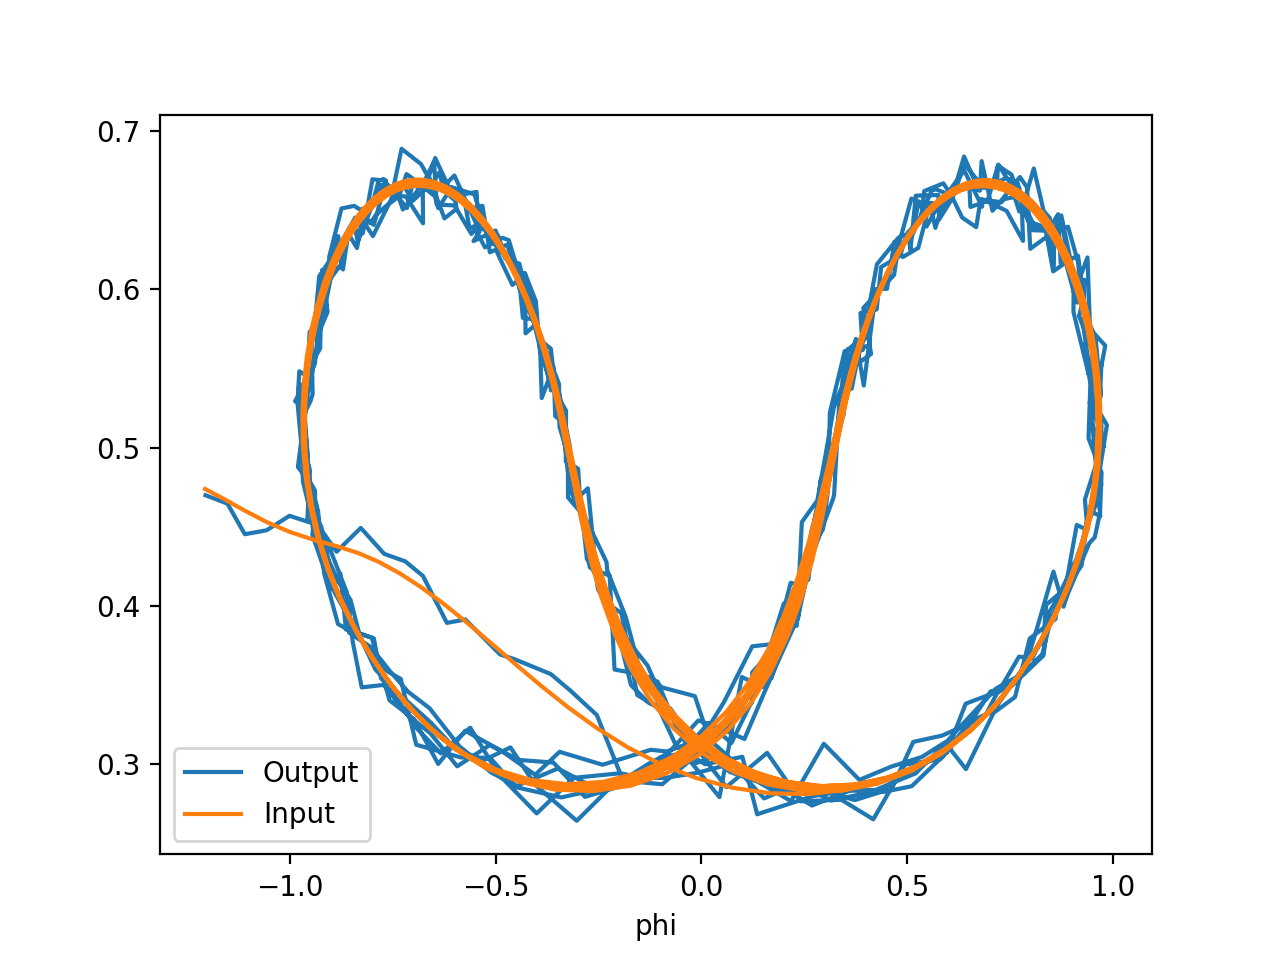

In [59]:
test_with = 2
nn_output_i = nn_output_test[test_with]
nn_input_i = nn_input_test[test_with]

fig,ax =plt.subplots()

nn_input_i.plot(x='phi', y='theta', label='Output', ax=ax)
nn_output_i.plot(x='phi', y='theta', label='Input', ax=ax)

In [52]:
model_simple.reset_states()
nn_input_i = nn_input_test[test_with]
nn_output_i = nn_output_test[test_with]


res = []

for i,in_i in nn_input_i.iterrows():
    rnn_in = in_i.to_numpy().reshape(1,-1)/x_scaling
    #rnn_in *= (1+0.1*np.random.randn(rnn_in.shape[0]))
    rnn_out = model_simple.predict(rnn_in.reshape(1,1,-1))*y_scaling
    res.append(rnn_out)
res = np.concatenate(res, axis=0).squeeze()
res_df = pd.DataFrame(res, columns = nn_output_i.keys())

In [60]:
res_df.index = np.arange(699)*0.15
nn_input_i.index = np.arange(699)*0.15
nn_output_i.index = np.arange(699)*0.15

<IPython.core.display.Javascript object>


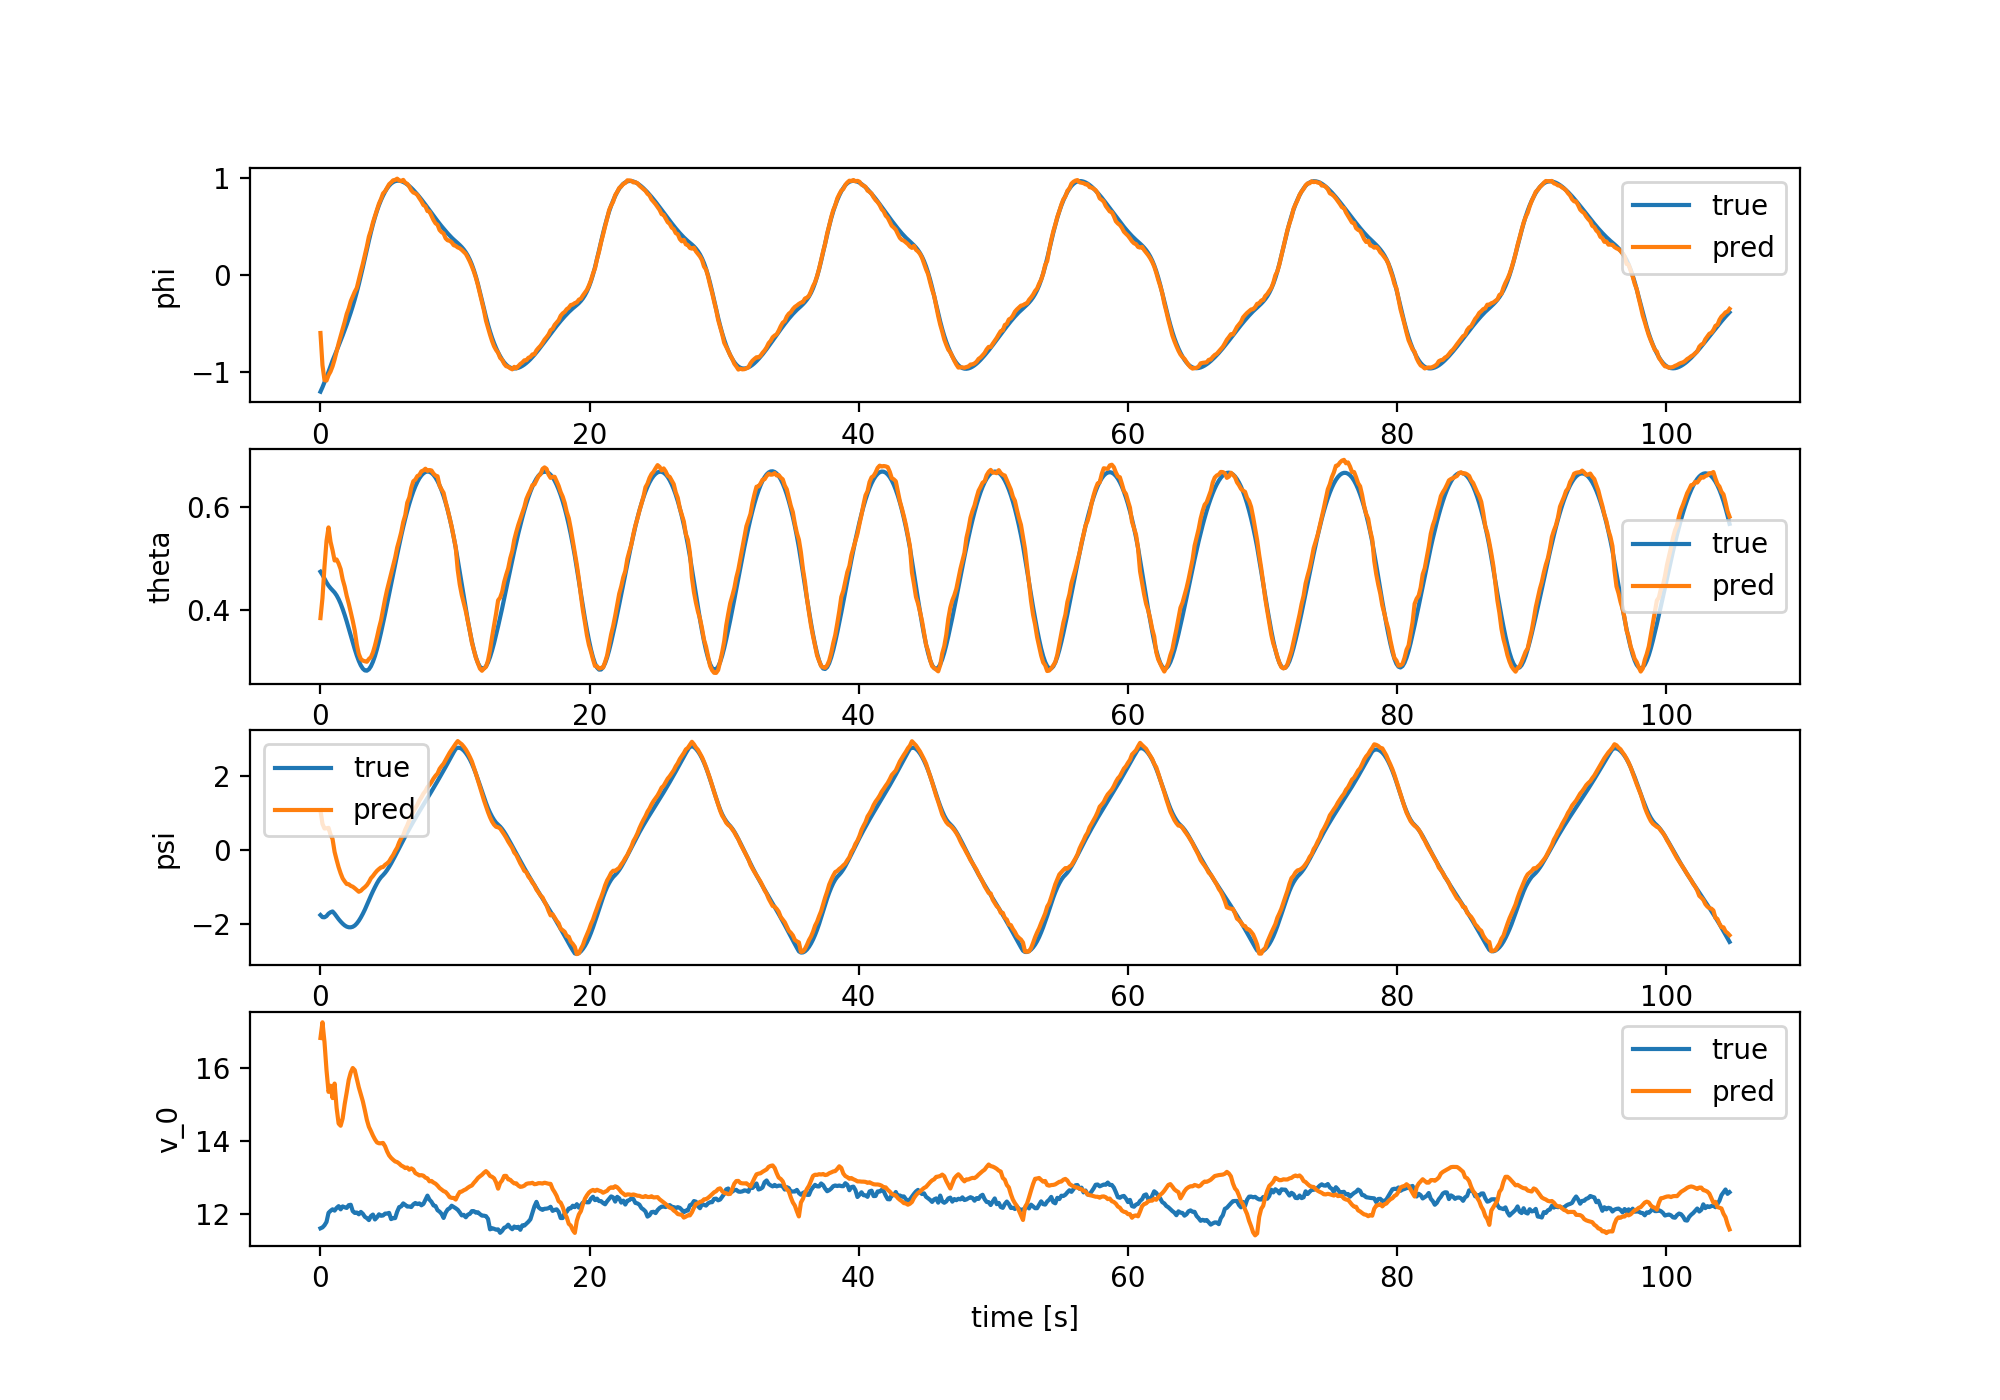

Text(0.5, 0, 'time [s]')

In [69]:
fig, ax = plt.subplots(4, figsize=(10,7))

nn_output_i.plot(y=['phi'], ax=ax[0], label=['true'])
res_df.plot(y=['phi'], ax=ax[0], label=['pred'])
#nn_input_i.plot(y=['phi'], ax=ax[0], label=['measured'])
ax[0].set_ylabel('phi')

nn_output_i.plot(y=['theta'], ax=ax[1], label=['true'])
#nn_input_i.plot(y=['theta'], ax=ax[1], label=['measured'])
res_df.plot(y=['theta'], ax=ax[1], label=['pred'])
ax[1].set_ylabel('theta')

nn_output_i.plot(y=['psi'], ax=ax[2], label=['true'])
res_df.plot(y=['psi'], ax=ax[2], label=['pred'])
ax[2].set_ylabel('psi')

# res_df.plot(y=['E_0'], ax=ax[3], label=['pred'])
# nn_output_i.plot(y=['E_0'], ax=ax[3], label=['true'])
# ax[3].set_ylabel('E_0')

nn_output_i.plot(y=['v_0'], ax=ax[3], label=['true'])
res_df.plot(y=['v_0'], ax=ax[3], label=['pred'])
ax[3].set_ylabel('v_0')
ax[3].set_xlabel('time [s]')

In [70]:
model_no = '012'

if True:
    model_simple.save_weights('./models/{model}_RNN/{model}_RNN_weights'.format(model=model_no))
    with open('./models/{model}_RNN/{model}_RNN_config.pkl'.format(model=model_no), 'wb') as f:
        pickle.dump({'model_param':model_param, 'y_scaling':y_scaling, 'x_scaling':x_scaling}, f)